### Autocorrelation analysis & convergence

https://emcee.readthedocs.io/en/stable/tutorials/autocorr/

In [1]:
import emcee
import numpy as np

def log_prob(p):
    return np.logaddexp(-0.5 * np.sum(p**2), -0.5 * np.sum((p - 4.0) ** 2))


sampler = emcee.EnsembleSampler(32, 3, log_prob)
sampler.run_mcmc(
    np.concatenate(
        (np.random.randn(16, 3), 4.0 + np.random.randn(16, 3)), axis=0
    ),
    500000,
    progress=True,
)

100%|█████████████████████████████████████████████████████████████| 500000/500000 [02:44<00:00, 3031.54it/s]


State([[ 4.34790293  3.5731143   3.98591368]
 [ 3.50524545  3.87048184  4.32043623]
 [ 0.40704182 -0.93793302 -0.28214803]
 [ 2.42641129  4.66904818  3.49708558]
 [-0.63789827  1.7129932   0.7081009 ]
 [-0.25596101 -0.43370225  0.25168732]
 [ 0.38328765  0.35039917 -1.24687165]
 [ 4.47178022  3.57172991  3.81376994]
 [ 4.62875093  3.89549952  6.54267619]
 [-0.23005337  1.53204485 -0.63261581]
 [-1.2864444   0.38607565  0.69802271]
 [ 5.0085268   4.2402232   3.44241886]
 [ 4.14238293  4.35613281  4.07803737]
 [ 1.38766198  0.58913338  0.67992721]
 [ 3.80945334  5.15150403  2.90189418]
 [ 5.49058911  3.9434329   4.33339278]
 [ 3.25690418  3.62456569  4.29685241]
 [ 2.88993694  4.69948477  4.02072359]
 [-0.91565859  0.93483158 -1.7651952 ]
 [ 2.61769171  4.94184557  3.85433206]
 [ 5.09274706  1.68662336  3.02060862]
 [ 6.03539593  2.69772582  4.56120932]
 [-0.31891036 -0.12010724 -0.98301581]
 [ 0.34263079 -0.5195324   0.5123401 ]
 [ 3.74402893  4.15694433  4.6099419 ]
 [ 4.69270513  3.20

Text(0, 0.5, '$p(\\theta)$')

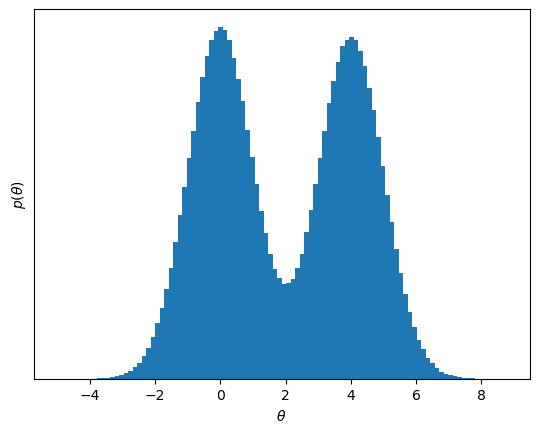

In [2]:
import matplotlib.pyplot as plt

chain = sampler.get_chain()[:, :, 0].T

plt.hist(chain.flatten(), 100)
plt.gca().set_yticks([])
plt.xlabel(r"$\theta$")
plt.ylabel(r"$p(\theta)$")

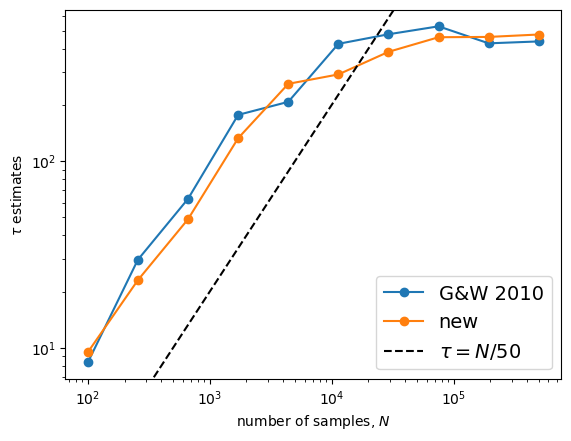

In [6]:
def next_pow_two(n):
    i = 1
    while i < n:
        i = i << 1
    return i

def autocorr_func_1d(x, norm=True):
    x = np.atleast_1d(x)
    if len(x.shape) != 1:
        raise ValueError("invalid dimensions for 1D autocorrelation function")
    n = next_pow_two(len(x))

    # Compute the FFT and then (from that) the auto-correlation function
    f = np.fft.fft(x - np.mean(x), n=2 * n)
    acf = np.fft.ifft(f * np.conjugate(f))[: len(x)].real
    acf /= 4 * n

    # Optionally normalize
    if norm:
        acf /= acf[0]

    return acf

def auto_window(taus, c):
    m = np.arange(len(taus)) < c * taus
    if np.any(m):
        return np.argmin(m)
    return len(taus) - 1

# Following the suggestion from Goodman & Weare (2010)
def autocorr_gw2010(y, c=5.0):
    f = autocorr_func_1d(np.mean(y, axis=0))
    taus = 2.0 * np.cumsum(f) - 1.0
    window = auto_window(taus, c)
    return taus[window]


def autocorr_new(y, c=5.0):
    f = np.zeros(y.shape[1])
    for yy in y:
        f += autocorr_func_1d(yy)
    f /= len(y)
    taus = 2.0 * np.cumsum(f) - 1.0
    window = auto_window(taus, c)
    return taus[window]

# Compute the estimators for a few different chain lengths
N = np.exp(np.linspace(np.log(100), np.log(chain.shape[1]), 10)).astype(int)
gw2010 = np.empty(len(N))
new = np.empty(len(N))
for i, n in enumerate(N):
    gw2010[i] = autocorr_gw2010(chain[:, :n])
    new[i] = autocorr_new(chain[:, :n])

# Plot the comparisons
plt.loglog(N, gw2010, "o-", label="G&W 2010")
plt.loglog(N, new, "o-", label="new")
ylim = plt.gca().get_ylim()
plt.plot(N, N / 50.0, "--k", label=r"$\tau = N/50$")
plt.ylim(ylim)
plt.xlabel("number of samples, $N$")
plt.ylabel(r"$\tau$ estimates")
plt.legend(fontsize=14)